### Packages

In [1]:
#requirements !pip freeze > requirements.txt.
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Load and Organise data

## Import data

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/askoshiyama/mli-cohort/master/german_credit.csv")
df.head()

,default,account_check_status,duration_in_month,credit_history,purpose,credit_amount,savings,present_emp_since,installment_as_income_perc,personal_status_sex,...,present_res_since,property,age,other_installment_plans,housing,credits_this_bank,job,people_under_maintenance,telephone,foreign_worker
0,0,< 0 DM,6,critical account/ other credits existing (not ...,domestic appliances,1169,unknown/ no savings account,.. >= 7 years,4,male : single,...,4,real estate,67,none,own,2,skilled employee / official,1,"yes, registered under the customers name",yes
1,1,0 <= ... < 200 DM,48,existing credits paid back duly till now,domestic appliances,5951,... < 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,...,2,real estate,22,none,own,1,skilled employee / official,1,none,yes
2,0,no checking account,12,critical account/ other credits existing (not ...,(vacation - does not exist?),2096,... < 100 DM,4 <= ... < 7 years,2,male : single,...,3,real estate,49,none,own,1,unskilled - resident,2,none,yes
3,0,< 0 DM,42,existing credits paid back duly till now,radio/television,7882,... < 100 DM,4 <= ... < 7 years,2,male : single,...,4,if not A121 : building society savings agreeme...,45,none,for free,1,skilled employee / official,2,none,yes
4,1,< 0 DM,24,delay in paying off in the past,car (new),4870,... < 100 DM,1 <= ... < 4 years,3,male : single,...,4,unknown / no property,53,none,for free,2,skilled employee / official,2,none,yes


## Pre-process variables

In [3]:
# variable types
df.dtypes

default                        int64
account_check_status          object
duration_in_month              int64
credit_history                object
purpose                       object
credit_amount                  int64
savings                       object
present_emp_since             object
installment_as_income_perc     int64
personal_status_sex           object
other_debtors                 object
present_res_since              int64
property                      object
age                            int64
other_installment_plans       object
housing                       object
credits_this_bank              int64
job                           object
people_under_maintenance       int64
telephone                     object
foreign_worker                object
dtype: object

In [4]:
# categorical variables
cat_variables = ['account_check_status', 'credit_history', 'purpose', 'savings', 'present_emp_since', 'personal_status_sex',
                'property', 'other_installment_plans', 'housing', 'job', 'telephone', "other_debtors", 'foreign_worker']

# target variable
output_variable = ["default"]

# other integer variables
int_variables = ['credits_this_bank', 'present_res_since', 'duration_in_month', 'people_under_maintenance', 
                 'installment_as_income_perc', 'age', 'credit_amount']
# list(set(df.columns) - set(output_variable) - set(cat_variables))

In [5]:
# pre-allocation
df_cat = pd.DataFrame(index=df.index)

# one-hot encoding of categorical variables
from sklearn.preprocessing import OneHotEncoder

# I will do a loop for pedagogical reasons, but it is not entirely necessary
for cat in cat_variables:
    # one-hot encoding fitting
    one_hot_func = OneHotEncoder().fit(df[[cat]])
    
    # mapping
    cat_mapped = one_hot_func.transform(df[[cat]]).toarray()
    
    # storing
    for (k, cat_label) in enumerate(one_hot_func.categories_[0]):
        df_cat[cat + "_" + cat_label] = cat_mapped[:, k]

# quick check
df_cat.mean()

account_check_status_0 <= ... < 200 DM                                        0.269
account_check_status_< 0 DM                                                   0.274
account_check_status_>= 200 DM / salary assignments for at least 1 year       0.063
account_check_status_no checking account                                      0.394
credit_history_all credits at this bank paid back duly                        0.049
credit_history_critical account/ other credits existing (not at this bank)    0.293
credit_history_delay in paying off in the past                                0.088
credit_history_existing credits paid back duly till now                       0.530
credit_history_no credits taken/ all credits paid back duly                   0.040
purpose_(vacation - does not exist?)                                          0.050
purpose_business                                                              0.097
purpose_car (new)                                                           

In [6]:
# bracketing integer variable - age
from sklearn.preprocessing import KBinsDiscretizer
kbin_func = KBinsDiscretizer(n_bins=3, encode='onehot', strategy='quantile').fit(df[["age"]])
df_age = pd.DataFrame(kbin_func.transform(df[["age"]]).toarray(), columns=["young", "adult", "senior"])

# checking
pd.concat([df_age, df[["age"]]], axis=1).head(10)

,young,adult,senior,age
0,0.0,0.0,1.0,67
1,1.0,0.0,0.0,22
2,0.0,0.0,1.0,49
3,0.0,0.0,1.0,45
4,0.0,0.0,1.0,53
5,0.0,1.0,0.0,35
6,0.0,0.0,1.0,53
7,0.0,1.0,0.0,35
8,0.0,0.0,1.0,61
9,0.0,1.0,0.0,28


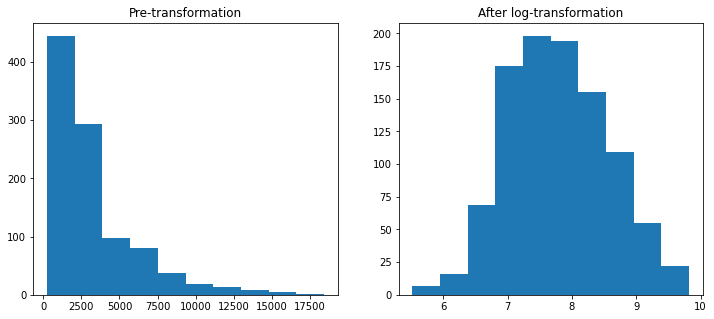

In [7]:
# other types of transformations possible - log transformation 
from sklearn.preprocessing import FunctionTransformer
log_mapping = FunctionTransformer(func=np.log, inverse_func=np.exp)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.hist(df["credit_amount"])
ax1.set_title("Pre-transformation")

ax2.hist(log_mapping.transform(df["credit_amount"]))
ax2.set_title("After log-transformation")
df_log = pd.DataFrame(log_mapping.transform(df["credit_amount"]).values, columns=["log(credit)"])

## Consolidating a final dataset

In [8]:
df_model = pd.concat([df[int_variables[:-2]], df_cat, df_age, df_log, df[output_variable]], axis=1)
df.shape, df_model.shape

((1000, 21), (1000, 64))

In [9]:
df_model.head()

,credits_this_bank,present_res_since,duration_in_month,people_under_maintenance,installment_as_income_perc,account_check_status_0 <= ... < 200 DM,account_check_status_< 0 DM,account_check_status_>= 200 DM / salary assignments for at least 1 year,account_check_status_no checking account,credit_history_all credits at this bank paid back duly,...,other_debtors_co-applicant,other_debtors_guarantor,other_debtors_none,foreign_worker_no,foreign_worker_yes,young,adult,senior,log(credit),default
0,2,4,6,1,4,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,7.063904,0
1,1,2,48,1,2,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,8.691315,1
2,1,3,12,2,2,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,7.647786,0
3,1,4,42,2,2,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,8.972337,0
4,2,4,24,2,3,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,8.490849,1


## Visualization: PCA, t-SNE

explained variance ratio (first two components): [0.9316043 0.0091663]


Text(0.5, 1.0, 'PCA of German Credit dataset')

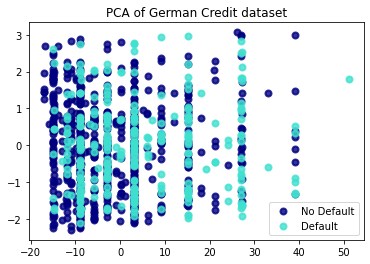

In [10]:
from sklearn.decomposition import PCA
X, y = df_model.drop(labels=output_variable, axis=1).values, df_model[output_variable].values
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
colors = ['navy', 'turquoise']
target_names = ["No Default", "Default"]
lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[(y == i).ravel(), 0], X_r[(y == i).ravel(), 1], color=color, alpha=.8, lw=lw, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of German Credit dataset')

Text(0.5, 1.0, 't-SNE of German Credit dataset')

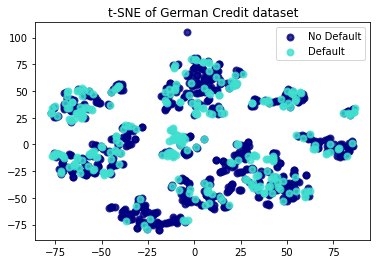

In [12]:
from sklearn.manifold import TSNE
X, y = df_model.drop(labels=output_variable, axis=1).values, df_model[output_variable].values
tsne = TSNE(n_components=2, init='random', random_state=0, perplexity=5)
X_r = tsne.fit_transform(X)

plt.figure()
colors = ['navy', 'turquoise']
target_names = ["No Default", "Default"]
lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[(y == i).ravel(), 0], X_r[(y == i).ravel(), 1], color=color, alpha=.8, lw=lw, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('t-SNE of German Credit dataset')    

# Modelling

## Kernel SVM: Grid-search + Stratified K-fold-CV

In [13]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold

# params
k_folds = StratifiedKFold(n_splits=10, random_state=10) # k-fold

hyper_params = {"kernel_svc__C": [10.0 ** -2, 10.0 ** -1, 10.0 ** 0, 10.0 ** 1, 10.00 ** 2],
                "kernel_svc__gamma": (np.array([10.0 ** -2, 10.0 ** -1, 10.0 ** 0, 10.0 ** 1, 10.0 ** 2]) * 1.0/df_model.shape[1]).tolist(),
                # [10.0 ** -3, 10.0 ** -2, 10.0 ** -1, 10.0 ** 0, 10.0 ** 1] * 1.0/df_model.shape[1],
                "kernel_svc__kernel": ["rbf"],
                "kernel_svc__probability": [True]
                }

# performance metrics
perf_metrics = {"Accuracy": metrics.accuracy_score, 
                "Precision": metrics.precision_score, 
                "Recall": metrics.recall_score,
                "AUC": metrics.roc_auc_score, 
                "F1-Score": metrics.f1_score, 
                "Brier": metrics.brier_score_loss
               }
for pf in perf_metrics:
    perf_metrics[pf] = metrics.make_scorer(perf_metrics[pf])

# main method
X, y = df_model.drop(labels=output_variable, axis=1).values, df_model[output_variable].values

model_pipeline = Pipeline([("scaler", StandardScaler()),
                           ("kernel_svc", SVC())]
                         )

model = GridSearchCV(estimator=model_pipeline, 
                     param_grid=hyper_params, 
                     scoring=perf_metrics, 
                     cv=k_folds, 
                     refit="F1-Score"
                    )
model.fit(X, y.ravel())

C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn

C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-pack

C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-pack

C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-pack

C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-pack

C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-pack

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=10, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('kernel_svc',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_i...
                         'kernel_svc__kernel': ['rbf'],
                         'kernel_svc__probability': [True]},
   

### Show results

In [14]:
# get best model
best_model = model.best_estimator_
best_model

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('kernel_svc',
                 SVC(C=100.0, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=0.0015625,
                     kernel='rbf', max_iter=-1, probability=True,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [15]:
# store all results and avg results in a df
df_cv = pd.DataFrame(model.cv_results_)

# add a hyperparameter column in avg df
from sklearn.model_selection import ParameterGrid
df_hyperparams = pd.DataFrame(list(ParameterGrid(model.param_grid)))
df_avgcv = pd.DataFrame(columns=perf_metrics.keys())
for pf in perf_metrics.keys():
    df_avgcv[pf] = df_cv["mean_test_" + pf]
df_avgcv = pd.concat([df_hyperparams, df_avgcv], axis=1)

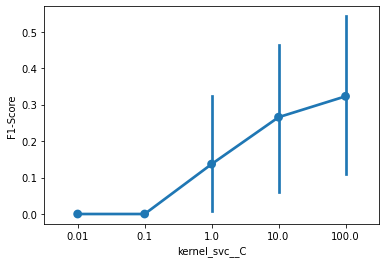

In [19]:
sns.pointplot(x="kernel_svc__C", y="F1-Score", data=df_avgcv)

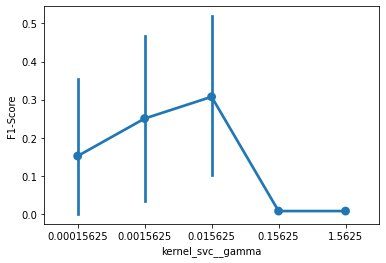

In [20]:
sns.pointplot(x="kernel_svc__gamma", y="F1-Score", data=df_avgcv)

In [21]:
df_avgcv.loc[df_avgcv["F1-Score"].idxmax()]

kernel_svc__C                    100
kernel_svc__gamma          0.0015625
kernel_svc__kernel               rbf
kernel_svc__probability         True
Accuracy                       0.765
Precision                   0.628157
Recall                      0.523333
AUC                         0.695952
F1-Score                    0.568641
Brier                          0.235
Name: 21, dtype: object

### Feature Importance chart

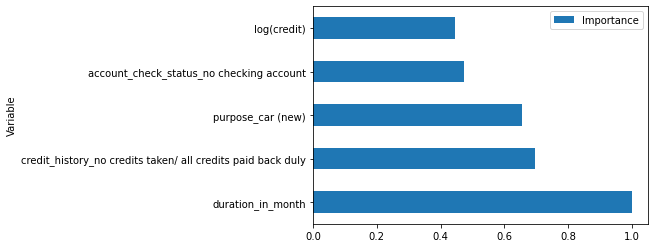

In [22]:
from sklearn.inspection import permutation_importance

feat_imp = permutation_importance(best_model, X, y, n_repeats=5, random_state=10)

df_featimp = pd.DataFrame({"Variable": df_model.drop(output_variable, axis=1).columns,
                           "Importance": feat_imp['importances_mean']/feat_imp["importances_mean"].max()})

df_featimp = df_featimp.sort_values("Importance", ascending=False)

# chart
df_featimp.iloc[:5].plot(x="Variable", y="Importance", kind="barh")

### Partial dependence plot

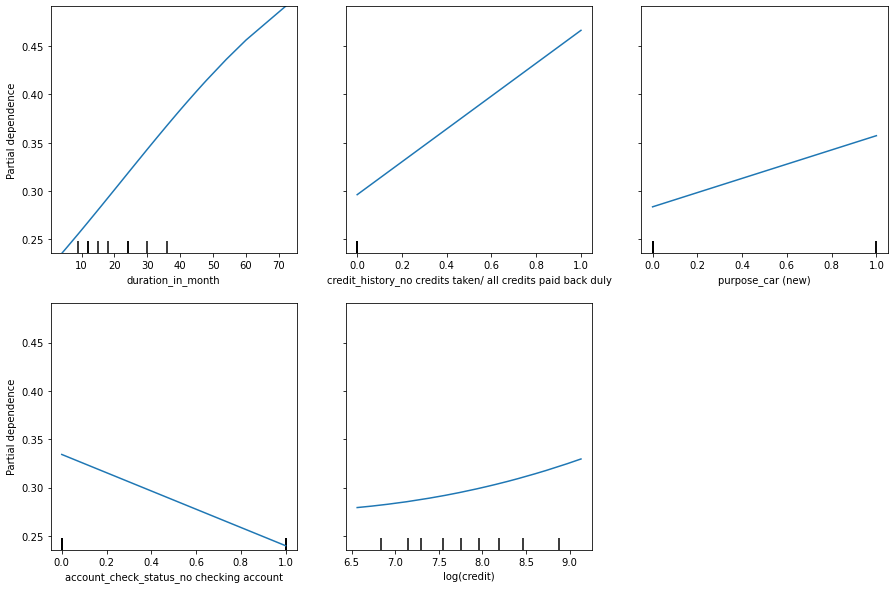

In [23]:
from sklearn.inspection import plot_partial_dependence
z = pd.DataFrame(X, columns=df_model.drop(output_variable, axis=1).columns)
fig, ax = plt.subplots(figsize=(15, 10))
plot_partial_dependence(best_model, z, df_featimp["Variable"].iloc[:5], 
                        ax=ax, response_method="predict_proba", 
                        method="brute", grid_resolution=200
                       ) 

C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\inspection\_partial_dependence.py:715: FutureWarning: The fig parameter is deprecated in version 0.22 and will be removed in version 0.24
  FutureWarning)


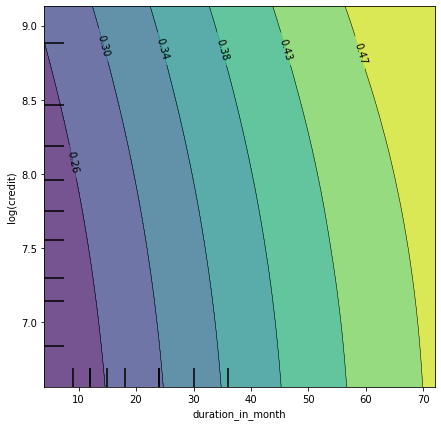

In [24]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_partial_dependence(best_model, z, [(df_featimp["Variable"].iloc[0], df_featimp["Variable"].iloc[4])], 
                        fig=fig, response_method="predict_proba", method="brute")

Text(0.5, 1.0, 't-SNE of German Credit dataset - Predicted')

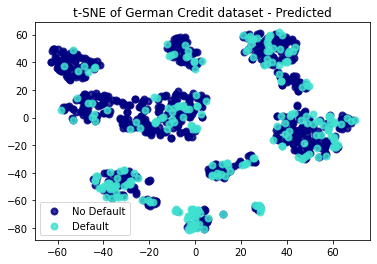

In [25]:
from sklearn.manifold import TSNE
X, y = df_model.drop(labels=output_variable, axis=1).values, best_model.predict(X)
tsne = TSNE(n_components=2, init='random', random_state=0, perplexity=10)
X_r = tsne.fit_transform(X)

plt.figure()
colors = ['navy', 'turquoise']
target_names = ["No Default", "Default"]
lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[(y == i).ravel(), 0], X_r[(y == i).ravel(), 1], color=color, alpha=.8, lw=lw, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('t-SNE of German Credit dataset - Predicted')    

Text(0.5, 1.0, 't-SNE of German Credit dataset - Observed')

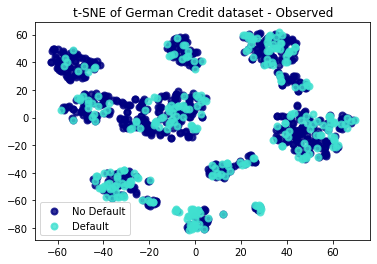

In [26]:
from sklearn.manifold import TSNE
X, y = df_model.drop(labels=output_variable, axis=1).values, df_model[output_variable].values
tsne = TSNE(n_components=2, init='random', random_state=0, perplexity=10)
X_r = tsne.fit_transform(X)

plt.figure()
colors = ['navy', 'turquoise']
target_names = ["No Default", "Default"]
lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[(y == i).ravel(), 0], X_r[(y == i).ravel(), 1], color=color, alpha=.8, lw=lw, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('t-SNE of German Credit dataset - Observed')    

## Reducing optimism bias in hyper-parameter optimization, and comparing strategies: Nested Cross-Validation/Resampling

### Initial Params

In [41]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# k-fold params
inner_folds = StratifiedKFold(n_splits=3, random_state=10) # inner k-fold
outer_folds = StratifiedKFold(n_splits=2, random_state=10) # outer k-fold

# models
model_dict = {"GBT": GradientBoostingClassifier(random_state=10),
              "Tree": DecisionTreeClassifier(random_state=10),
              
              "MLP": Pipeline([("std", StandardScaler()), 
                               ("mlp", MLPClassifier(random_state=10))]),
              
              "KNN": Pipeline([("std", StandardScaler()),
                               ("knn", KNeighborsClassifier())]),
              
              "Logistic": LogisticRegression(penalty="none", solver="lbfgs"),
              "LassoLogistic": Pipeline([("std", StandardScaler()), 
                                         ("lasso", LogisticRegression(penalty="l1", solver='liblinear'))]),
              "ElasticNet": Pipeline([("std", StandardScaler()), 
                                      ("en", LogisticRegression(penalty="elasticnet", solver="saga"))]),
              "UnifRandom": DummyClassifier(strategy="uniform"), 
              "StratRandom": DummyClassifier(strategy="stratified"),
              "SVM": Pipeline([("std", StandardScaler()), 
                               ("svc", SVC(kernel="rbf", probability=True))])
             }

# models hyperparams
hyper_params = {"GBT": {"learning_rate": [10.0 ** -1, 10.0 ** 0, 2.0],
                        "max_depth": [1, 2, 3],
                        "max_features": [0.1, 0.25, 0.5],
                        "n_estimators": [200]},
                
                "Tree": {"max_depth": [1, 3, 5, 7, 9],
                         "class_weight": [None, "balanced"]},
                
                "MLP": {"mlp__hidden_layer_sizes": [(5,), (10,), (50,)], 
                        "mlp__activation": ['relu', 'tanh']
                       },
                "KNN": {"knn__n_neighbors": [1, 3, 5, 7]
                       },
                "Logistic": {"class_weight": [None, "balanced"]},
                
                "LassoLogistic": {"lasso__C": [10.0 ** -4, 10.0 ** -3, 10.0 ** -2, 10.0 ** -1, 10.0 ** 0],
                                  "lasso__class_weight": [None, "balanced"]},
                
                "ElasticNet": {"en__C": [10.0 ** -4, 10.0 ** -3, 10.0 ** -2, 10.0 ** -1, 10.0 ** -0],
                               "en__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
                               "en__class_weight": [None, "balanced"]},
                
                "UnifRandom": {},
                "StratRandom": {},
                
                "SVM": {"svc__C": [10.0 ** -2, 10.0 ** -1, 10.0 ** 0, 10.0 ** 1, 10.00 ** 2], 
                        "svc__gamma": (np.array([10.0 ** -2, 10.0 ** -1, 10.0 ** 0, 10.0 ** 1, 10.0 ** 2]) * 1.0/df_model.shape[1]).tolist(),
                        "svc__class_weight": [None, "balanced"]}
                }

# performance metrics
perf_metrics = {"Accuracy": metrics.accuracy_score, 
                "Precision": metrics.precision_score, 
                "Recall": metrics.recall_score,
                "AUC": metrics.roc_auc_score, 
                "F1-Score": metrics.f1_score, 
                "Brier": metrics.brier_score_loss}
scorer_metrics = {}
for pf in perf_metrics:
    scorer_metrics[pf] = metrics.make_scorer(perf_metrics[pf])

C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


### Fitting models

In [42]:
# pre-allocation
X, y = df_model.drop(labels=output_variable, axis=1).values, df_model[output_variable].values
k, z, innercv_results, inner_best_model = 0, 0, {}, {}
df_outer_results = pd.DataFrame(index=[0], columns=["Model"] + list(perf_metrics.keys()))

# outer loop
for (out_train, out_test) in outer_folds.split(X, y):
    # separation: train, test
    Xtrain, Xtest = X[out_train], X[out_test]
    ytrain, ytest = y[out_train], y[out_test]
        
    
    # inner loop -- all models -- hyperparameter fine-tuning
    innercv_results["fold_" + str(k)] = {}
    inner_best_model["fold_" + str(k)] = {}
    
    for class_model in model_dict.keys():
        print((k, class_model))
        innercv_results["fold_" + str(k)][class_model] = GridSearchCV(estimator=model_dict[class_model], 
                                                                       param_grid=hyper_params[class_model], 
                                                                       scoring=scorer_metrics, 
                                                                       cv=inner_folds, 
                                                                       refit="F1-Score")
        innercv_results["fold_" + str(k)][class_model].fit(Xtrain, ytrain.ravel())
        inner_best_model["fold_" + str(k)][class_model] = innercv_results["fold_" + str(k)][class_model].best_estimator_
    
    # prediction -- all models -- compute performance metrics at the same level playing field
    for class_model in model_dict.keys():
        # prediction
        ypred_class = inner_best_model["fold_" + str(k)][class_model].predict(Xtest)
        ypred_prob = inner_best_model["fold_" + str(k)][class_model].predict_proba(Xtest)[:, 1]
        df_outer_results.loc[z, "Model"] = class_model
    
        # compute performance metrics
        for pf in perf_metrics.keys():
            if pf in ["AUC", "Brier"]:
                df_outer_results.loc[z, pf] = perf_metrics[pf](ytest, ypred_prob)
            else:
                df_outer_results.loc[z, pf] = perf_metrics[pf](ytest, ypred_class)
        z += 1
    
    # iteration
    k += 1

# final organisation
df_outer_results[list(perf_metrics.keys())] = df_outer_results[list(perf_metrics.keys())].astype(float)

(0, 'GBT')


C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0, 'Tree')


C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0, 'MLP')


C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations 

(0, 'KNN')
(0, 'Logistic')


C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stabl

(0, 'LassoLogistic')


C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-pack

(0, 'ElasticNet')


C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-pack

C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-pack

C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklea

(0, 'UnifRandom')
(0, 'StratRandom')
(0, 'SVM')


C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-pack

C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-pack

C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-pack

C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-pack

(1, 'GBT')


C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-pack

(1, 'Tree')
(1, 'MLP')


C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations 

(1, 'KNN')
(1, 'Logistic')


C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stabl

(1, 'LassoLogistic')
(1, 'ElasticNet')


C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-pack

C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-pack

C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklea

(1, 'UnifRandom')
(1, 'StratRandom')
(1, 'SVM')


C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-pack

C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-pack

C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\envs\mli4\lib\site-pack

In [43]:
df_outer_results[list(perf_metrics.keys())] = df_outer_results[list(perf_metrics.keys())].astype(float)

### Show results

In [44]:
df_outer_results.pivot_table(index=["Model"], aggfunc="mean")

,AUC,Accuracy,Brier,F1-Score,Precision,Recall
Model,,,,,,
ElasticNet,0.773543,0.722,0.194298,0.603789,0.527109,0.706667
GBT,0.749505,0.731,0.219896,0.532210,0.557093,0.510000
KNN,0.616905,0.681,0.319000,0.462206,0.468347,0.456667
LassoLogistic,0.768167,0.699,0.199441,0.599057,0.498810,0.750000
Logistic,0.758771,0.713,0.202919,0.586704,0.515990,0.680000
MLP,0.739476,0.730,0.200826,0.526321,0.555824,0.500000
SVM,0.776767,0.708,0.169054,0.602123,0.509154,0.736667
StratRandom,0.513333,0.570,0.408000,0.303344,0.294108,0.313333
Tree,0.671905,0.602,0.220187,0.560636,0.419137,0.846667


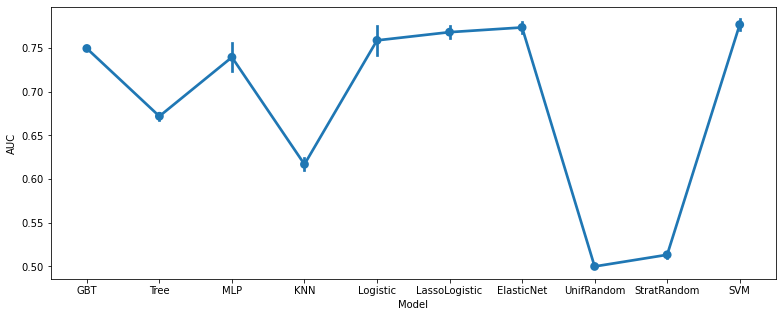

In [45]:
fig, ax = plt.subplots(1,1,figsize=(13,5))
sns.pointplot(x="Model", y="AUC", data=df_outer_results, ax=ax)

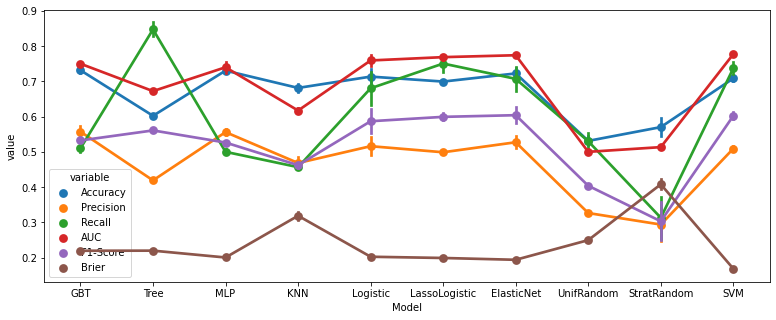

In [46]:
df_melt = df_outer_results.melt(id_vars=["Model"], value_vars=list(perf_metrics.keys()))
fig, ax = plt.subplots(1,1,figsize=(13,5))
sns.pointplot(x="Model", y="value", hue="variable", data=df_melt, ax=ax)

In [47]:
df_outer_results.pivot_table(index=["Model"], aggfunc="mean")

,AUC,Accuracy,Brier,F1-Score,Precision,Recall
Model,,,,,,
ElasticNet,0.773543,0.722,0.194298,0.603789,0.527109,0.706667
GBT,0.749505,0.731,0.219896,0.532210,0.557093,0.510000
KNN,0.616905,0.681,0.319000,0.462206,0.468347,0.456667
LassoLogistic,0.768167,0.699,0.199441,0.599057,0.498810,0.750000
Logistic,0.758771,0.713,0.202919,0.586704,0.515990,0.680000
MLP,0.739476,0.730,0.200826,0.526321,0.555824,0.500000
SVM,0.776767,0.708,0.169054,0.602123,0.509154,0.736667
StratRandom,0.513333,0.570,0.408000,0.303344,0.294108,0.313333
Tree,0.671905,0.602,0.220187,0.560636,0.419137,0.846667


In [48]:
a = df_outer_results.pivot_table(index=["Model"], aggfunc="mean")
a[["Brier"]] = 1 - a[["Brier"]]
a.rank()

,AUC,Accuracy,Brier,F1-Score,Precision,Recall
Model,,,,,,
ElasticNet,9.0,8.0,9.0,10.0,8.0,7.0
GBT,6.0,10.0,5.0,5.0,10.0,4.0
KNN,3.0,4.0,2.0,3.0,4.0,2.0
LassoLogistic,8.0,5.0,8.0,8.0,5.0,9.0
Logistic,7.0,7.0,6.0,7.0,7.0,6.0
MLP,5.0,9.0,7.0,4.0,9.0,3.0
SVM,10.0,6.0,10.0,9.0,6.0,8.0
StratRandom,2.0,2.0,1.0,1.0,1.0,1.0
Tree,4.0,3.0,4.0,6.0,3.0,10.0


In [49]:
a.rank().mean(axis=1)

Model
ElasticNet       8.500000
GBT              6.666667
KNN              3.000000
LassoLogistic    7.166667
Logistic         6.666667
MLP              6.166667
SVM              8.166667
StratRandom      1.333333
Tree             5.000000
UnifRandom       2.333333
dtype: float64

# Other Topics

## Scalable models

### Create dataset with different sizes

In [ ]:
# small
df_model_small = df_model.copy()

# medium
for k in range(10):
    if k==0:
        df_model_medium = df_model.copy()
    else:
        df_model_medium = pd.concat([df_model_medium, df_model.copy()], axis=0, ignore_index=True)
        
# large
for k in range(100):
    if k==0:
        df_model_large = df_model.copy()
    else:
        df_model_large = pd.concat([df_model_large, df_model.copy()], axis=0, ignore_index=True)

### GBT

In [ ]:
from time import time
from sklearn.ensemble import GradientBoostingClassifier
# small
start = time()
GradientBoostingClassifier(n_estimators=100).fit(df_model_small.drop(output_variable, axis=1), 
                                                 df_model_small[output_variable])
print(time() - start)

# medium
start = time()
GradientBoostingClassifier(n_estimators=100).fit(df_model_medium.drop(output_variable, axis=1), 
                                                 df_model_medium[output_variable])
print(time() - start)

# large
start = time()
GradientBoostingClassifier(n_estimators=100).fit(df_model_large.drop(output_variable, axis=1), 
                                                 df_model_large[output_variable])
print(time() - start)

### LightGBM - https://lightgbm.readthedocs.io/en/latest/index.html

In [ ]:
from lightgbm import LGBMClassifier
from time import time
from sklearn.ensemble import GradientBoostingClassifier
# small
start = time()
LGBMClassifier(n_estimators=100).fit(df_model_small.drop(output_variable, axis=1).values, 
                                                 df_model_small[output_variable].values)
print(time() - start)

# medium
start = time()
LGBMClassifier(n_estimators=100).fit(df_model_medium.drop(output_variable, axis=1).values, 
                                                 df_model_medium[output_variable].values)
print(time() - start)

# large
start = time()
LGBMClassifier(n_estimators=100).fit(df_model_large.drop(output_variable, axis=1).values, 
                                                 df_model_large[output_variable].values)
print(time() - start)

### (SGDClassifier, Linear SVM) + Feature Mapping - almost a kernel approach

#### Nystroem

In [ ]:
from sklearn.kernel_approximation import Nystroem
nyst = Nystroem(gamma=0.001, n_components=2)
nyst.fit_transform(X)

In [ ]:
X, y = df_model.drop(labels=output_variable, axis=1).values, df_model[output_variable].values
nyst = Nystroem(gamma=.01, n_components=2)
X_r = nyst.fit_transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
colors = ['navy', 'turquoise']
target_names = ["No Default", "Default"]
lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[(y == i).ravel(), 0], X_r[(y == i).ravel(), 1], color=color, alpha=.8, lw=lw, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of German Credit dataset')

#### Initial params

In [ ]:
#### from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.kernel_approximation import Nystroem
from lightgbm import LGBMClassifier

# k-fold params
inner_folds = StratifiedKFold(n_splits=3, random_state=10) # inner k-fold
outer_folds = StratifiedKFold(n_splits=5, random_state=10) # outer k-fold

# models
model_dict = {"LightGBM": LGBMClassifier(random_state=10),
              "SGD": Pipeline([("std", StandardScaler()),
                               ("map", Nystroem(random_state=10)),
                               ("sgd", SGDClassifier(random_state=10))]),
              "LinearSVM": Pipeline([("std", StandardScaler()),
                                     ("map", Nystroem(random_state=10)),
                                     ("sgd", LinearSVC(dual=False, random_state=10))])
             }

# models hyperparams
hyper_params = {"LightGBM": {"learning_rate": [10.0 ** -1, 10.0 ** 0, 2.0],
                             "max_depth": [1, 2, 3],
                             "max_features": [0.1, 0.25, 0.5],
                             "n_estimators": [200]},
                "SGD": {"sgd__loss": ["hinge", "log"],
                        "sgd__alpha": [0.01, 0.1, 1.0, 10.0],
                        "sgd__class_weight": [None, "balanced"],
                        "sgd__eta0": [0.001, 0.01, 0.1],
                        "sgd__max_iter": [100],
                        "map__gamma": [0.0001, 0.001, 0.01, 0.1]},
                "LinearSVM": {"sgd__C": [0.01, 0.1, 1.0, 10.0],
                              "sgd__class_weight": [None, "balanced"],
                              "map__gamma": [0.0001, 0.001, 0.01, 0.1]}
               }

# performance metrics
perf_metrics = {"Accuracy": metrics.accuracy_score, 
                "Precision": metrics.precision_score, 
                "Recall": metrics.recall_score,
               # "AUC": metrics.roc_auc_score, 
                "F1-Score": metrics.f1_score, 
               # "Brier": metrics.brier_score_loss
               }
scorer_metrics = {}
for pf in perf_metrics:
    scorer_metrics[pf] = metrics.make_scorer(perf_metrics[pf])

#### Fit models

In [ ]:
# pre-allocation
X, y = df_model_medium.drop(labels=output_variable, axis=1).values, df_model_medium[output_variable].values
k, z, innercv_results, inner_best_model = 0, 0, {}, {}
df_outer_results = pd.DataFrame(index=[0], columns=["Model", "Time"] + list(perf_metrics.keys()))

# outer loop
for (out_train, out_test) in outer_folds.split(X, y):
    # separation: train, test
    Xtrain, Xtest = X[out_train], X[out_test]
    ytrain, ytest = y[out_train], y[out_test]
    
    # inner loop -- all models
    innercv_results["fold_" + str(k)] = {}
    inner_best_model["fold_" + str(k)] = {}
    start, end = [], []
    for class_model in model_dict.keys():
        start.append(time())
        print((k, class_model))
        innercv_results["fold_" + str(k)][class_model] = GridSearchCV(estimator=model_dict[class_model], 
                                                                       param_grid=hyper_params[class_model], 
                                                                       scoring=scorer_metrics, 
                                                                       cv=inner_folds, 
                                                                       refit="F1-Score")
        innercv_results["fold_" + str(k)][class_model].fit(Xtrain, ytrain.ravel())
        inner_best_model["fold_" + str(k)][class_model] = innercv_results["fold_" + str(k)][class_model].best_estimator_
        end.append(time())
    
    # outer loop prediction
    for (v, class_model) in enumerate(model_dict.keys()):
        # prediction
        ypred_class = inner_best_model["fold_" + str(k)][class_model].predict(Xtest)
        df_outer_results.loc[z, "Model"] = class_model
        df_outer_results.loc[z, "Time"] = end[v] - start[v]
    
        # compute performance metrics
        for pf in perf_metrics.keys():
            df_outer_results.loc[z, pf] = perf_metrics[pf](ytest, ypred_class)
        z += 1
    
    # iteration
    k += 1

# final organisation
df_outer_results[list(perf_metrics.keys()) + ["Time"]] = df_outer_results[list(perf_metrics.keys()) + ["Time"]].astype(float)

#### Show results

In [ ]:
df_outer_results.pivot_table(index=["Model"], aggfunc="mean")

### Deep Gaussian Processes

#### https://gpytorch.ai/

## Other Hyperparameter optimizers

### Bayesian Optimization

#### https://scikit-optimize.github.io/#skopt.gp_minimize

### Tree of Parzen Estimators

#### https://github.com/hyperopt/hyperopt

### Evolutionary Strategies

#### https://deap.readthedocs.io/en/master/

## Explainable Models

### Explainable Boosting Machines

#### https://github.com/microsoft/interpret

### SHAP

#### https://github.com/slundberg/shap

### LIME

#### https://github.com/marcotcr/lime

### Captum

#### https://github.com/pytorch/captum?fbclid=IwAR0P_CvwX-dkUztoUBrcfFDygGGIHRt775pwik86npEUiKuUKudtx55kRDw

## Dealing with time series

### Cross-validation schemes

#### https://github.com/askoshiyama/tsdata-mvapi

### Scikit-learn for time series

#### https://github.com/alan-turing-institute/sktime

### Amazon GluonTS

#### https://github.com/awslabs/gluon-ts